# AT&T Spam Detector
#### <i>Author: Delphine César<i>

## Table of contents

<ul>
   <li><a href="#import">I - Import of librairies and dataset</a></li>
   <li><a href="#info">II - Dataset information</a></li>
   <li><a href="#engineering">III - Data engineering</a></li>
   <li><a href="#dl">IV - Deep Learning</a></li>
      <ul>
         <li><a href="#preprocessing">1 - Preprocessing</a></li>
         <li><a href="#model">2 - Model</a></li>
         <li><a href="#evaluation">3 - Model evaluation</a></li>
      </ul>
</ul>

<a id='import'></a>
### I - Import of librairies and dataset

In [23]:
import pandas as pd

import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [2]:
# Import dataset with Pandas
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",error_bad_lines=False, encoding="ISO-8859-1")

<ipython-input-2-640a363f5806>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",error_bad_lines=False, encoding="ISO-8859-1")


<a id='info'></a>
### II - Dataset information

In [3]:
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

<a id='engineering'></a>
### III - Data engineering

In [4]:
cols_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
dataset = dataset.drop(cols_to_drop, axis=1)

We delete the last 3 columns as they have almost only missing values

In [5]:
# Renaming the columns
dataset.rename (columns={"v1":"label", "v2": "text"}, inplace=True)

In [6]:
# Replacing values
dataset['label'] = dataset['label'].apply(lambda x: 0 if x == 'ham' else 1)
dataset.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print("Basics statistics: ")
display(dataset.describe(include='all'))
print()

print("Target repartition: ")
dataset['label'].value_counts()

Basics statistics: 


,label,text
count,5572.000000,5572
unique,NaN,5169
top,NaN,"Sorry, I'll call later"
freq,NaN,30
mean,0.134063,NaN
std,0.340751,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN



Target repartition: 


0    4825
1     747
Name: label, dtype: int64

<a id='dl'></a>
### IV - Deep Learning

<a id='preprocessing'></a>
##### 1 - Preprocessing

In [8]:
nlp = en_core_web_sm.load()

In [9]:
# Remove all non alphanumeric characters except whitespaces
dataset["text_clean"] = dataset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

dataset.head()

,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


Cleaning and pre-processing of text data by removing special characters normalizing case, lemmatizing words and filtering out stop words.

In [10]:
# Tokenizer with only 1000 most common words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset.text_clean)
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text_clean)
dataset["len_text"] = dataset["text_encoded"].apply(lambda x: len(x))
dataset = dataset[dataset["len_text"]!=0]

We use a tokenizer to convert the 1000 most frequent words in our dataset, into a numerical representation.

In [11]:
# We use "padding" to be sure that all the sequences have the same length.
text_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.text_encoded, padding="post")

In [12]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(text_pad,dataset.label, test_size=0.3, stratify=dataset.label)

In [13]:
# We create the tensor dataset for the training, and validation set.
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [14]:
# We organise the training and validation sets by batches of 64 observations.
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [15]:
 # let's vizualise a batch
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 60   0   0 ...   0   0   0]
 [787 113 426 ...   0   0   0]
 [ 98  99  26 ...   0   0   0]
 ...
 [727  87   0 ...   0   0   0]
 [  9 143   1 ...   0   0   0]
 [ 59   5 856 ...   0   0   0]], shape=(64, 47), dtype=int32) tf.Tensor(
[0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


<a id='model'></a>
##### 2 - Model

In [16]:
# Architecture of the model
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  GlobalAveragePooling1D(),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 8)             8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________



We build a neural network model that uses different layers to process text.
- The word embedding layer converts words into numbers.
- The global average pooling layer calculates the average of each word in the sentence in all dimensions.
- The 2 denses layers use two different activation functions.

In [17]:
# We compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
dataset['label'].value_counts()

0    4668
1     745
Name: label, dtype: int64

Since the dataset is unbalanced, we'll add weights when training our model to avoid bias

In [19]:
weights = 1/(dataset['label']).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index, values in zip(weights.index, weights.values)}
weights

{0: 0.5797986289631534, 1: 3.632885906040268}

In [20]:
# Fit the model on epochs
history = model.fit(train_batch,
                    epochs=30,
                    validation_data=val_batch,
                    class_weight=weights
                    )

Epoch 1/30
60/60 [==============================] - 1s 6ms/step - loss: 0.6886 - accuracy: 0.8625 - val_loss: 0.6600 - val_accuracy: 0.8639
Epoch 2/30
60/60 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.9021 - val_loss: 0.6223 - val_accuracy: 0.8867
Epoch 3/30
60/60 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.9082 - val_loss: 0.5743 - val_accuracy: 0.9224
Epoch 4/30
60/60 [==============================] - 0s 4ms/step - loss: 0.6015 - accuracy: 0.9261 - val_loss: 0.5288 - val_accuracy: 0.9667
Epoch 5/30
60/60 [==============================] - 0s 3ms/step - loss: 0.5358 - accuracy: 0.9596 - val_loss: 0.4565 - val_accuracy: 0.9723
Epoch 6/30
60/60 [==============================] - 0s 4ms/step - loss: 0.4516 - accuracy: 0.9715 - val_loss: 0.3509 - val_accuracy: 0.9760
Epoch 7/30
60/60 [==============================] - 0s 3ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.3001 - val_accuracy: 0.9754
Epoch 8/30
60/60 [==

<a id='evaluation'></a>
##### 3 - Model evaluation

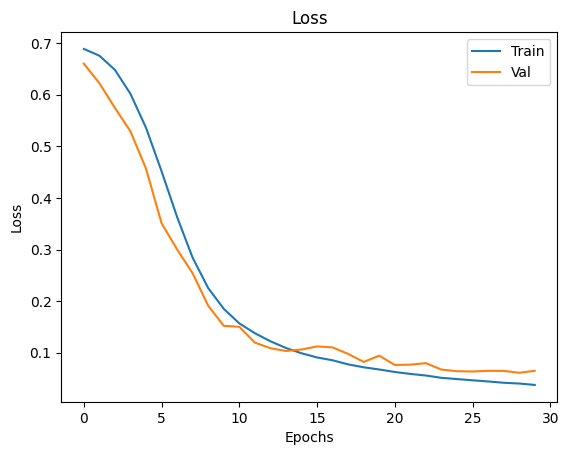

In [21]:
# Visualization of the training process on the loss function
plt.plot(model.history.history["loss"], label = "Train")
plt.plot(model.history.history["val_loss"], label="Val")
plt.gca().set(title='Loss',xlabel='Epochs',ylabel='Loss')
plt.legend()
plt.show()

The model seems to learn fast and start overfitting after 13 epochs.

51/51 [==============================] - 0s 938us/step


<Axes: >

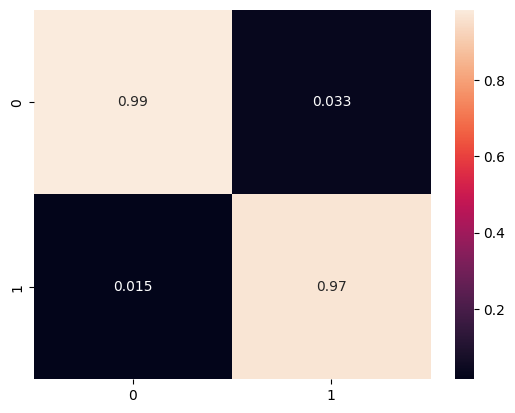

In [24]:
# Confusion matrix
ypred = model.predict(xval)
ypred = np.where(ypred > 0.5, 1, 0)

result = confusion_matrix(yval, ypred, normalize="pred")

plt.figure()
sn.heatmap(result, annot=True)


The model results are good. It predicts true positives 99% of the time, true negatives 97% of the time, and is only slightly wrong.